In [1]:
import pandas as pd
import numpy as np
import os
#import shutil
import matplotlib.pyplot as plt
#from sklearn.preprocessing import quantile_transform
import itertools
from scipy.stats import linregress
from scipy.stats import spearmanr
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# read in big bac csv file
big = pd.read_csv("~/combat_results/big_after_ComBat2.csv") 
# for big dataset, make rownames
#big = big.iloc[:, 1:]           # Step 1: remove the first column
big.index = big.iloc[:, 0]      # Step 2: set the new first column as index
big = big.iloc[:, 1:]           # Step 3: drop that column from the data
print(big.iloc[:6, :6])

                 PRJDB10485_DRR243823  PRJDB10485_DRR243824  \
Unnamed: 0                                                    
Acidaminococcus            -19.916319            -19.916319   
Actinomyces                -19.920788            -19.920788   
Acutalibacter              -19.904559              3.022243   
Adlercreutzia                8.967888              8.822689   
Agathobaculum              -19.899449              5.545255   
Akkermansia                -19.908716             10.513457   

                 PRJDB10485_DRR243825  PRJDB10485_DRR243826  \
Unnamed: 0                                                    
Acidaminococcus            -19.916319            -19.916319   
Actinomyces                -19.920788            -19.920788   
Acutalibacter              -19.904559            -19.904559   
Adlercreutzia              -19.908758            -19.908758   
Agathobaculum              -19.899449              1.023547   
Akkermansia                 10.849675            -19.9

In [3]:
# read in small bac file 
small = pd.read_csv("~/combat_results/small_after_ComBat2.csv") 
# for small dataset, make rownames
#small = small.iloc[:, 1:]           # Step 1: remove the first column
small.index = small.iloc[:, 0]      # Step 2: set the new first column as index
small = small.iloc[:, 1:]           # Step 3: drop that column from the data
print(small.iloc[:6, :6])

                 PD1SS17052dna201907dbDec22  PD117Pittsdna201907dbDec22  \
Unnamed: 0                                                                
Acidaminococcus                  -27.905575                  -12.215861   
Actinomyces                      -25.442331                  -11.086597   
Acutalibacter                     -7.687554                   -5.058617   
Adlercreutzia                    -14.089484                  -11.075905   
Agathobaculum                     -5.720465                    1.030011   
Akkermansia                       -0.835710                  -11.503600   

                 PD1SS17005dna201907dbDec22  PD1TPF1820dna201907dbDec22  \
Unnamed: 0                                                                
Acidaminococcus                  -13.776716                   -7.002818   
Actinomyces                      -25.442331                   -8.562088   
Acutalibacter                     -0.925561                   -6.607248   
Adlercreutzia           

In [4]:
# Log2 transform with a small offset
big_log = big.T     # Transpose to have samples as rows
small_log = small.T
big_samples = big_log.index.tolist()
small_samples = small_log.index.tolist()
# Standardize
scaler = StandardScaler()
big_scaled = scaler.fit_transform(big_log)
#small_scaled = scaler.fit_transform(small_log)
small_scaled = scaler.transform(small_log)

In [5]:
# save scaled files
feature_names = big.index  # if big was a DataFrame originally
sample_names_big = big.columns
sample_names_small = small.columns

big_scaled_df = pd.DataFrame(big_scaled, index=sample_names_big, columns=feature_names)
small_scaled_df = pd.DataFrame(small_scaled, index=sample_names_small, columns=feature_names)

# Save to CSV
#big_scaled_df.to_csv("/ix/hpark/Jie/LMM/big_scaled_combat2.csv")
#small_scaled_df.to_csv("/ix/hpark/Jie/LMM/small_scaled_combat2.csv")

In [6]:
import umap.umap_ as umap
# Combine for UMAP
combined_scaled = np.vstack([big_scaled, small_scaled])
combined_samples = big_samples + small_samples
group_labels = ['big'] * len(big_samples) + ['small'] * len(small_samples)

2025-10-13 04:36:26.848756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 04:36:26.858077: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 04:36:26.888596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-13 04:36:26.888616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-13 04:36:26.889574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

/ihome/hpark/jis117/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


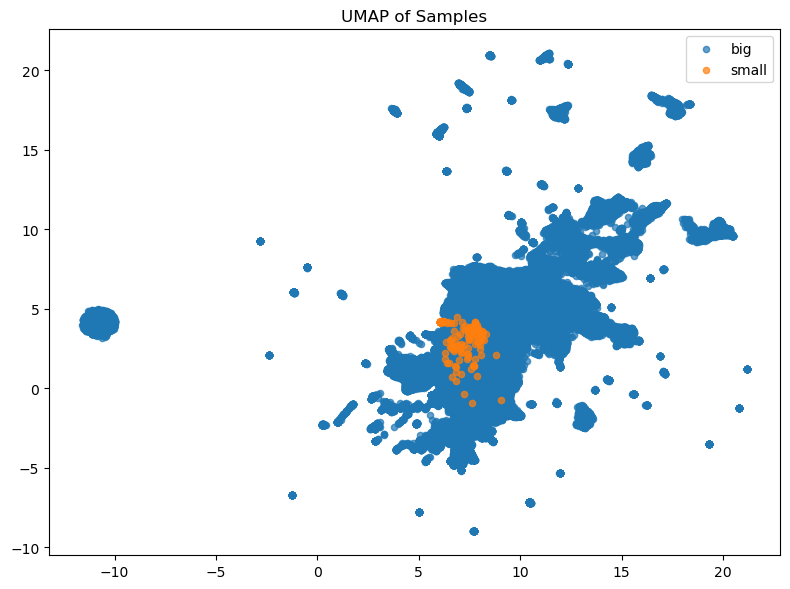

In [7]:
# Run UMAP on combined data
from sklearn.decomposition import PCA
pca = PCA(n_components=50).fit_transform(combined_scaled)
umap_model = umap.UMAP(n_neighbors=30, random_state=42)
umap_embedded = umap_model.fit_transform(pca)

# Create a dataframe
df_umap = pd.DataFrame(umap_embedded, columns=['UMAP1', 'UMAP2'])
df_umap['sample'] = combined_samples
df_umap['group'] = group_labels

# Plot UMAP with all samples
plt.figure(figsize=(8,6))
for grp in df_umap['group'].unique():
    subset = df_umap[df_umap['group'] == grp]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=grp, alpha=0.7, s=20)
plt.title('UMAP of Samples')
plt.legend()
plt.tight_layout()
plt.savefig("/ix/hpark/Jie/LMM/Figure/S.Fig4E_UMAP_orig.pdf", format="pdf")
plt.show()

In [ ]:
df_umap['group'].value_counts()

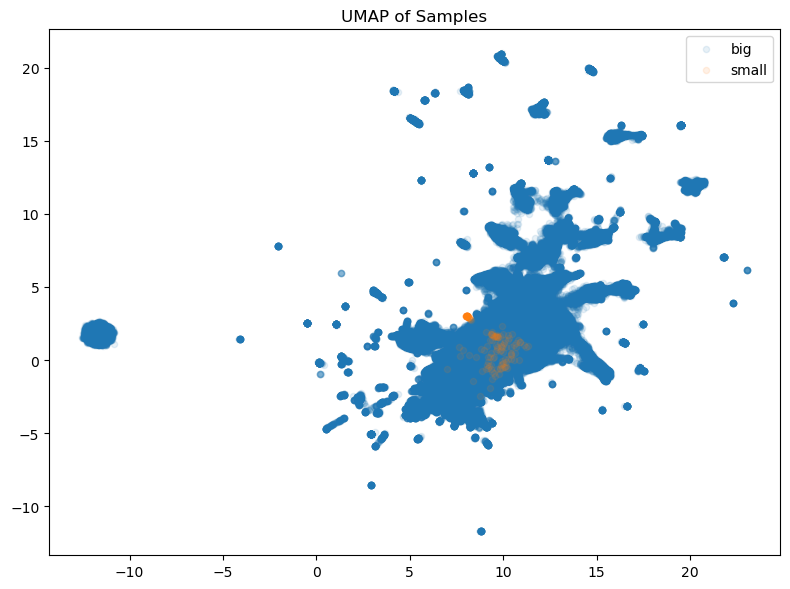

In [10]:
# Plot UMAP with all samples
plt.figure(figsize=(8,6))
for grp in df_umap['group'].unique():
    subset = df_umap[df_umap['group'] == grp]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=grp, alpha=0.1, s=20)
plt.title('UMAP of Samples')
plt.legend()
plt.tight_layout()
plt.show()

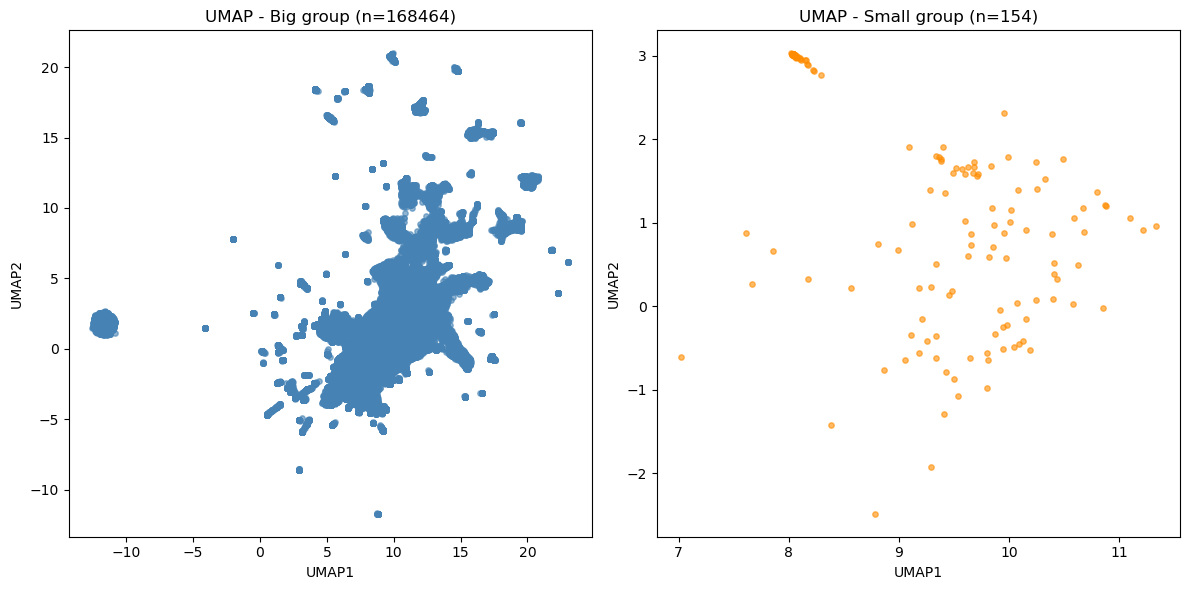

In [11]:
# Separate dataframes
df_big = df_umap[df_umap['group'] == 'big']
df_small = df_umap[df_umap['group'] == 'small']

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Big group
axes[0].scatter(df_big['UMAP1'], df_big['UMAP2'], s=15, alpha=0.6, color='steelblue')
axes[0].set_title(f"UMAP - Big group (n={len(df_big)})")
axes[0].set_xlabel("UMAP1")
axes[0].set_ylabel("UMAP2")

# Small group
axes[1].scatter(df_small['UMAP1'], df_small['UMAP2'], s=15, alpha=0.6, color='darkorange')
axes[1].set_title(f"UMAP - Small group (n={len(df_small)})")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")

plt.tight_layout()
plt.show()


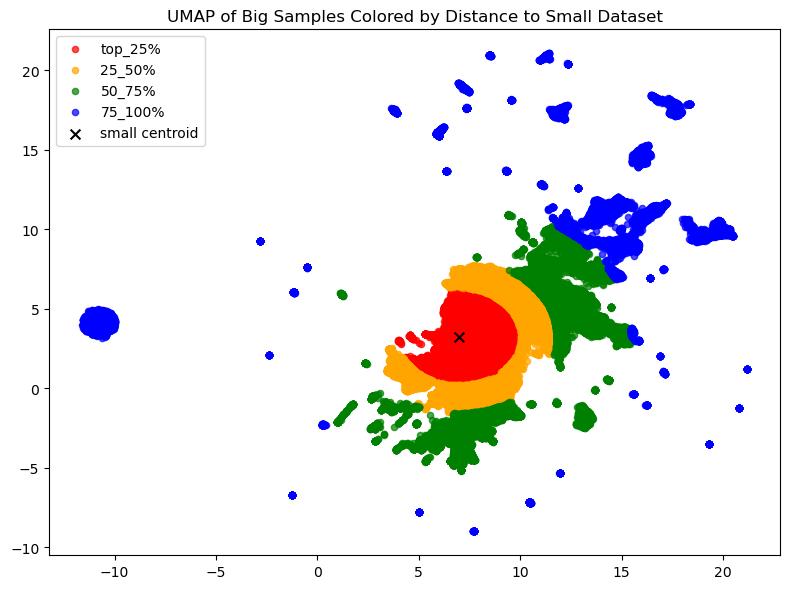

In [8]:
# 2️⃣ Split embeddings
big_umap = umap_embedded[:len(big_samples), :]
small_umap = umap_embedded[len(big_samples):, :]

# 3️⃣ Compute distance from each big sample to the **centroid** of small samples
small_center = small_umap.mean(axis=0)
distances = np.linalg.norm(big_umap - small_center, axis=1)  # Euclidean distance

# 4️⃣ Assign quantile groups
quantiles = np.quantile(distances, [0.25, 0.5, 0.75])
groups = []
for d in distances:
    if d <= quantiles[0]:
        groups.append('top_25%')
    elif d <= quantiles[1]:
        groups.append('25_50%')
    elif d <= quantiles[2]:
        groups.append('50_75%')
    else:
        groups.append('75_100%')

# 5️⃣ Add to dataframe for plotting
df_umap = pd.DataFrame(big_umap, columns=['UMAP1','UMAP2'], index=big_samples)
df_umap['group'] = groups

# 6️⃣ Plot
plt.figure(figsize=(8,6))
colors = {'top_25%':'red','25_50%':'orange','50_75%':'green','75_100%':'blue'}
for grp, color in colors.items():
    subset = df_umap[df_umap['group']==grp]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], label=grp, s=20, color=color, alpha=0.7)
plt.scatter(small_center[0], small_center[1], c='black', marker='x', s=50, label='small centroid')
plt.title('UMAP of Big Samples Colored by Distance to Small Dataset')
plt.legend()
plt.tight_layout()
plt.savefig("/ix/hpark/Jie/LMM/Figure/S.Fig4F_UMAP_distance.pdf", format="pdf")
plt.show()


In [13]:
# 7️⃣ Return 4 dataframes with selected samples
dfs_by_group = {}
for grp in ['top_25%','25_50%','50_75%','75_100%']:
    selected_samples = df_umap[df_umap['group']==grp].index
    dfs_by_group[grp] = big[selected_samples].T  # bacteria matrix


In [14]:
output_dir = "/ix/hpark/Jie/LMM/UMAP_dist_combat2/"  # change to your desired folder
os.makedirs(output_dir, exist_ok=True)

for grp, df in dfs_by_group.items():
    filename = os.path.join(output_dir, f"big_samples_{grp}.csv")
    df.to_csv(filename)
    print(f"Saved {grp} to {filename}")

Saved top_25% to /ix/hpark/Jie/LMM/UMAP_dist_combat2/big_samples_top_25%.csv
Saved 25_50% to /ix/hpark/Jie/LMM/UMAP_dist_combat2/big_samples_25_50%.csv
Saved 50_75% to /ix/hpark/Jie/LMM/UMAP_dist_combat2/big_samples_50_75%.csv
Saved 75_100% to /ix/hpark/Jie/LMM/UMAP_dist_combat2/big_samples_75_100%.csv


In [30]:
print(dfs_by_group["top_25%"].shape)
print(dfs_by_group["25_50%"].shape)
print(dfs_by_group["50_75%"].shape)
print(dfs_by_group["75_100%"].shape)

(42116, 104)
(42116, 104)
(42116, 104)
(42116, 104)
